<a href="https://colab.research.google.com/github/zahir49/Customer_Churn_Analysis_Prediction/blob/main/Customer_Churn_Analysis_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
import pandas as pd 
# Load required libraries
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-whitegrid")

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

from sklearn.model_selection import GridSearchCV
import scipy.stats as stat
import pylab 

#import library used for counting the number of observations
from collections import Counter

pd.pandas.set_option('display.max_columns',None)

In [ ]:
df_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Files/Telco-Customer-Churn.csv')
df_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
df_data.shape

(7043, 21)

In [ ]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


**Data cleaning**

In [ ]:
#Check for null values
df_data.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

**TotalCharges feature:**

---

The feature 'TotalCharges' has float values but it's data type is object. First we will find the index positions that have the space(i.e missing value). Then we will replace the spaces with null value and convert the data-type of 'TotalCharges' feature to 'float64'. Next we will impute the missing values with the median value of this feature.

In [ ]:
#Convert to float type
# df_data['TotalCharges'] = df_data['TotalCharges'].astype('float64')

In [ ]:
#Index of rows that have a blank space i.e. it is a null value
na_index = df_data[df_data['TotalCharges'].apply(lambda x: x.isspace())==True].index
print(na_index)

Int64Index([488, 753, 936, 1082, 1340, 3331, 3826, 4380, 5218, 6670, 6754], dtype='int64')


In [ ]:
# Fill the 11 blank values with the np.nan
df_data['TotalCharges'] = df_data['TotalCharges'].replace(' ', np.nan)
#Convert to float type
df_data['TotalCharges'] = df_data['TotalCharges'].astype('float64')

In [ ]:
#Replace the 11 missing values with median of the feature
df_data['TotalCharges']=df_data['TotalCharges'].fillna(df_data['TotalCharges'].median())

In [ ]:
# Drop customerID feature as it is not required
df_data.drop('customerID', axis=1, inplace=True)

In [ ]:
#Apart from 'SeniorCitizen' feature, all the other features have values like Yes/No. So we will map 0 to No and 1 to Yes for the 'SeniorCitizen' feature.
df_data['SeniorCitizen']=df_data['SeniorCitizen'].map({0:'No', 1:'Yes'})

In [ ]:
df_data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


**EDA**

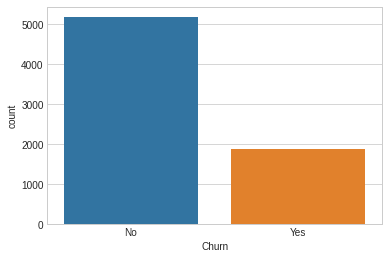

In [ ]:
#Check the data distribution of Target feature
sns.countplot(x="Churn", data=df_data)

In [ ]:
df_data['Churn'].value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

This is an imbalanced data as the number of 'No' is far greater than the number of 'Yes' in our dataset
73% data is for 'No' and remaining 27% data is for 'Yes'

In [ ]:
# Getting categorical and numerical features
cat_cols = [cname for cname in df_data.columns if df_data[cname].dtype=='object' and cname!='Churn']
num_cols = [cname for cname in df_data.columns if df_data[cname].dtype!='object']

print('categorical features: ', cat_cols)
print('numerical features: ', num_cols)

categorical features:  ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
numerical features:  ['tenure', 'MonthlyCharges', 'TotalCharges']


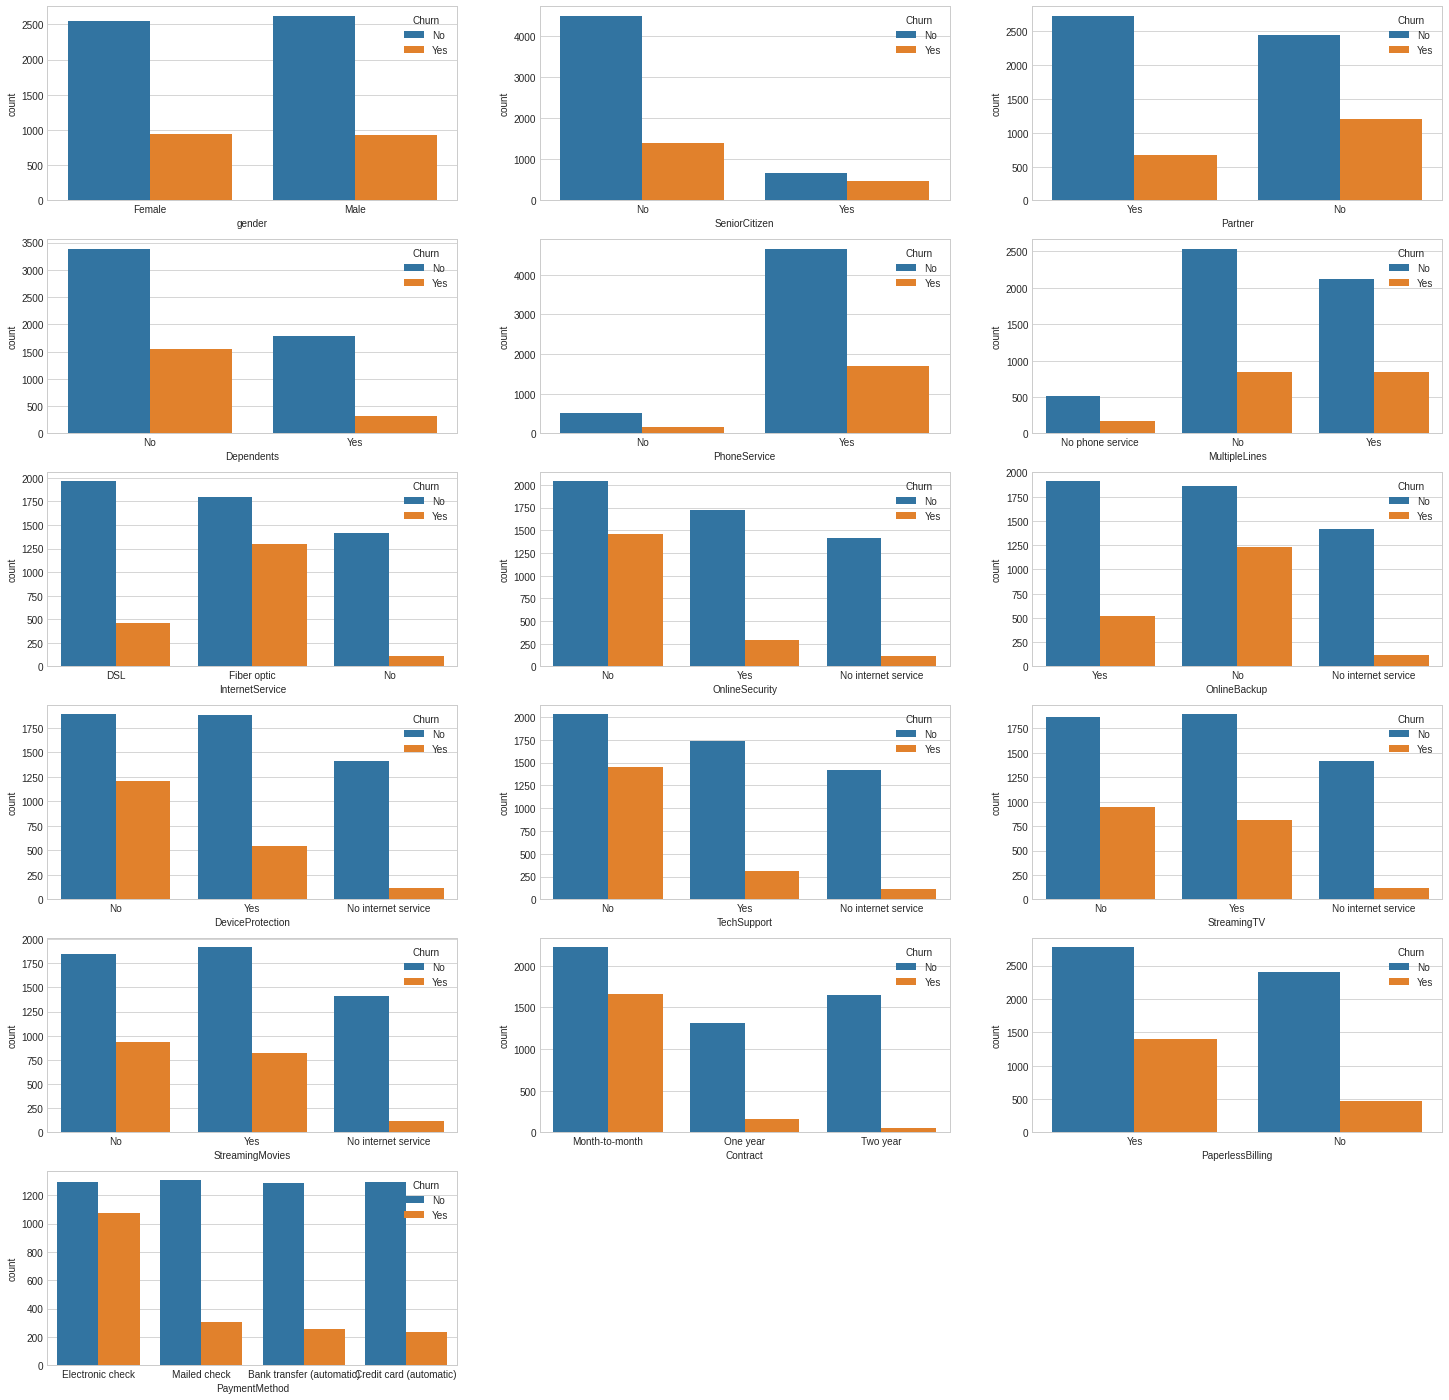

In [ ]:
#Plotting the impact of categorical features on 'Churn'
plt.figure(figsize=(25,25))
for i,cat in enumerate(cat_cols):
    plt.subplot(6,3,i+1)
    sns.countplot(data = df_data, x= cat, hue = "Churn")
plt.show()

In [ ]:
#We will try to create groups based on the 'tenure' feature
df_data['tenure'].describe()

count    7043.000000
mean       32.371149
std        24.559481
min         0.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: tenure, dtype: float64

In [ ]:
df_data['tenure_grp'] = pd.cut(df_data['tenure'], bins=[0,12,24,36,48,60,np.inf], labels=['0to12', '13to24', '25to36', '37to48', '49to60', '60above'])

In [ ]:
df_data['tenure_grp'].value_counts()

0to12      2175
60above    1407
13to24     1024
25to36      832
49to60      832
37to48      762
Name: tenure_grp, dtype: int64

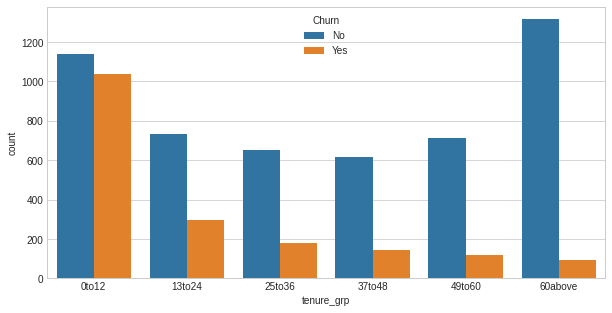

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(data=df_data, x='tenure_grp',hue = "Churn")

In [ ]:
df_data.drop('tenure', axis=1, inplace=True)

In [ ]:
df_data.describe()

,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000
mean,64.761692,2281.916928
std,30.090047,2265.270398
min,18.250000,18.800000
25%,35.500000,402.225000
50%,70.350000,1397.475000
75%,89.850000,3786.600000
max,118.750000,8684.800000


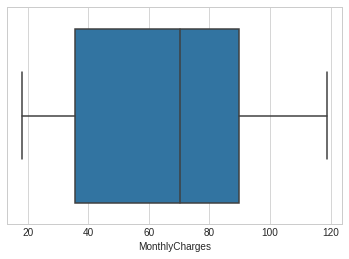

In [ ]:
sns.boxplot(df_data['MonthlyCharges'])

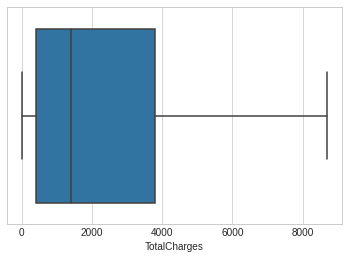

In [ ]:
sns.boxplot(df_data['TotalCharges'])

There are no outliers in the numerical features

In [ ]:
#Mapping target feature
df_data['Churn']=df_data['Churn'].map({'No':0, 'Yes':1})

In [ ]:
#Remove the spaces in between the categorical features
cat_cols = [cname for cname in df_data.columns if df_data[cname].dtype=='object' and cname!='Churn']
for cname in cat_cols:
    df_data[cname] = df_data[cname].str.replace(" ","_")

In [ ]:
df_data['PaymentMethod'].value_counts()

Electronic_check             2365
Mailed_check                 1612
Bank_transfer_(automatic)    1544
Credit_card_(automatic)      1522
Name: PaymentMethod, dtype: int64

In [ ]:
df_data['PaymentMethod']=df_data['PaymentMethod'].map({'Electronic_check': 'EC', 'Mailed_check': 'MC',
                                                      'Bank_transfer_(automatic)': 'BTAuto',
                                                      'Credit_card_(automatic)': 'CCAuto'})

df_data.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_grp
0,Female,No,Yes,No,No,No_phone_service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,EC,29.85,29.85,0,0to12
1,Male,No,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One_year,No,MC,56.95,1889.50,0,25to36
2,Male,No,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,MC,53.85,108.15,1,0to12
3,Male,No,No,No,No,No_phone_service,DSL,Yes,No,Yes,Yes,No,No,One_year,No,BTAuto,42.30,1840.75,0,37to48
4,Female,No,No,No,Yes,No,Fiber_optic,No,No,No,No,No,No,Month-to-month,Yes,EC,70.70,151.65,1,0to12


In [ ]:
#convert categorical data into dummy variables
df_data_dummy = pd.get_dummies(df_data,drop_first=True)
df_data_dummy.head()


,MonthlyCharges,TotalCharges,Churn,gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No_phone_service,MultipleLines_Yes,InternetService_Fiber_optic,InternetService_No,OnlineSecurity_No_internet_service,OnlineSecurity_Yes,OnlineBackup_No_internet_service,OnlineBackup_Yes,DeviceProtection_No_internet_service,DeviceProtection_Yes,TechSupport_No_internet_service,TechSupport_Yes,StreamingTV_No_internet_service,StreamingTV_Yes,StreamingMovies_No_internet_service,StreamingMovies_Yes,Contract_One_year,Contract_Two_year,PaperlessBilling_Yes,PaymentMethod_CCAuto,PaymentMethod_EC,PaymentMethod_MC,tenure_grp_13to24,tenure_grp_25to36,tenure_grp_37to48,tenure_grp_49to60,tenure_grp_60above
0,29.85,29.85,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
1,56.95,1889.50,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0
2,53.85,108.15,1,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
3,42.30,1840.75,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
4,70.70,151.65,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0


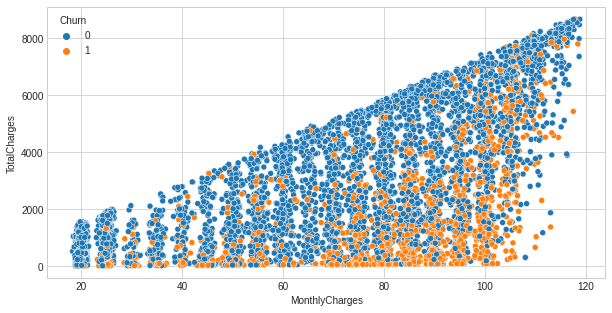

In [ ]:
plt.figure(figsize=(10,5))
sns.scatterplot(x='MonthlyCharges', y='TotalCharges', data=df_data_dummy, hue='Churn')

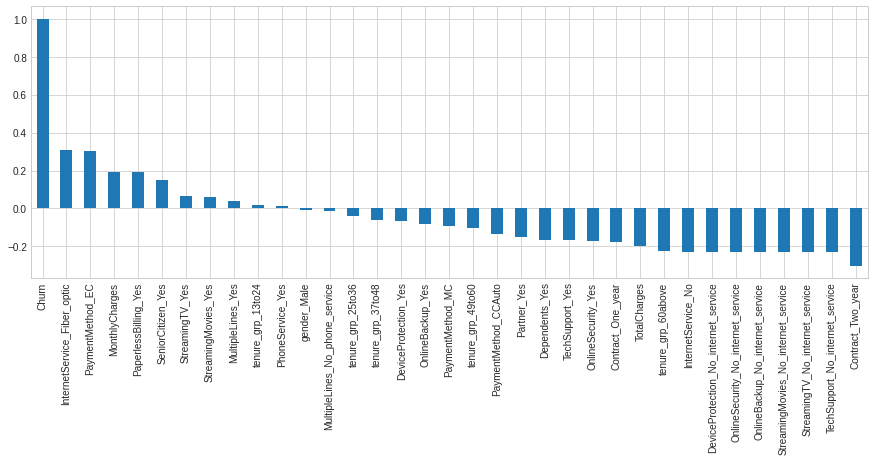

In [ ]:
plt.figure(figsize=(15,5))
df_data_dummy.corr()['Churn'].sort_values(ascending = False).plot(kind='bar')

**Model building**

In [ ]:
df_data_model = df_data_dummy.copy(deep=True)
df_data_model.head()

,MonthlyCharges,TotalCharges,Churn,gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No_phone_service,MultipleLines_Yes,InternetService_Fiber_optic,InternetService_No,OnlineSecurity_No_internet_service,OnlineSecurity_Yes,OnlineBackup_No_internet_service,OnlineBackup_Yes,DeviceProtection_No_internet_service,DeviceProtection_Yes,TechSupport_No_internet_service,TechSupport_Yes,StreamingTV_No_internet_service,StreamingTV_Yes,StreamingMovies_No_internet_service,StreamingMovies_Yes,Contract_One_year,Contract_Two_year,PaperlessBilling_Yes,PaymentMethod_CCAuto,PaymentMethod_EC,PaymentMethod_MC,tenure_grp_13to24,tenure_grp_25to36,tenure_grp_37to48,tenure_grp_49to60,tenure_grp_60above
0,29.85,29.85,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
1,56.95,1889.50,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0
2,53.85,108.15,1,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
3,42.30,1840.75,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
4,70.70,151.65,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0


In [ ]:
df_data_model.columns

Index(['MonthlyCharges', 'TotalCharges', 'Churn', 'gender_Male',
       'SeniorCitizen_Yes', 'Partner_Yes', 'Dependents_Yes',
       'PhoneService_Yes', 'MultipleLines_No_phone_service',
       'MultipleLines_Yes', 'InternetService_Fiber_optic',
       'InternetService_No', 'OnlineSecurity_No_internet_service',
       'OnlineSecurity_Yes', 'OnlineBackup_No_internet_service',
       'OnlineBackup_Yes', 'DeviceProtection_No_internet_service',
       'DeviceProtection_Yes', 'TechSupport_No_internet_service',
       'TechSupport_Yes', 'StreamingTV_No_internet_service', 'StreamingTV_Yes',
       'StreamingMovies_No_internet_service', 'StreamingMovies_Yes',
       'Contract_One_year', 'Contract_Two_year', 'PaperlessBilling_Yes',
       'PaymentMethod_CCAuto', 'PaymentMethod_EC', 'PaymentMethod_MC',
       'tenure_grp_13to24', 'tenure_grp_25to36', 'tenure_grp_37to48',
       'tenure_grp_49to60', 'tenure_grp_60above'],
      dtype='object')

In [ ]:
X = df_data_model.loc[:, df_data_model.columns!='Churn']
y = df_data_model['Churn']

SMOTE technique is used to handle the imbalanced dataset.

In [ ]:
smote = SMOTE()
# fit predictor and target variable
X_smote, y_smote = smote.fit_resample(X,y)
print('Original dataset shape', Counter(y))
print('Resample dataset shape', Counter(y_smote))

Original dataset shape Counter({0: 5174, 1: 1869})
Resample dataset shape Counter({0: 5174, 1: 5174})


The resampled data is then split into train and test data for validation

In [ ]:
# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X_smote, y_smote, train_size=0.7, test_size=0.3, random_state=0)
# summarize
print('Train', X_train.shape, y_train.shape)
print('Test', X_valid.shape, y_valid.shape)

Train (7243, 34) (7243,)
Test (3105, 34) (3105,)


Random Forest Classifier

In [ ]:
model_rf=RandomForestClassifier(n_estimators=100, criterion='gini', random_state = 100,max_depth=6, min_samples_leaf=8)

In [ ]:
model_rf.fit(X_train,y_train)

RandomForestClassifier(max_depth=6, min_samples_leaf=8, random_state=100)

In [ ]:
y_pred=model_rf.predict(X_valid)

In [ ]:
# Model accuracy score
model_rf.score(X_valid,y_valid)

0.8128824476650564

In [ ]:
print(classification_report(y_valid, y_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.85      0.76      0.80      1547
           1       0.78      0.86      0.82      1558

    accuracy                           0.81      3105
   macro avg       0.82      0.81      0.81      3105
weighted avg       0.82      0.81      0.81      3105



In [ ]:
print(metrics.confusion_matrix(y_valid, y_pred))

[[1178  369]
 [ 212 1346]]
